In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as functional

torch.set_default_dtype(torch.float32)
import torch.optim as optim
import pickle
import math
# from sys import exit
import matplotlib.pyplot as plt
from sklearn import datasets

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from generative_model import realnvpfc_model

# Three examples of 2D toy loglikelihood

In [2]:
# Example 1 - Gaussian mixture
x1, y1, a1, sigma1 = -0.5, -0.5, 1, 0.4
x2, y2, a2, sigma2 = -0.5, 0.5, 1, 0.4
x3, y3, a3, sigma3 = 0.5, -0.5, 1, 0.4
x4, y4, a4, sigma4 = 0.5, 0.5, 1, 0.4
log_prob1 = lambda x, y: torch.log(a1 * torch.exp(-1/sigma1**2*((x-x1)**2+(y-y1)**2)) + \
                        a2 * torch.exp(-1/sigma2**2*((x-x2)**2+(y-y2)**2)) + \
                        a3 * torch.exp(-1/sigma3**2*((x-x3)**2+(y-y3)**2)) + \
                        a4 * torch.exp(-1/sigma4**2*((x-x4)**2+(y-y4)**2)))

# Example 2 - double crescent
log_prob2 = lambda x, y: -0.5 * ((torch.sqrt((4*x)**2 + (4*y)**2)-2)/0.6)**2 + \
                        torch.log(torch.exp(-0.5 * (4*x-2)**2/0.6**2)+torch.exp(-0.5 * (4*x+2)**2/0.6**2))

# Example 3 - sinusoidal
log_prob3 = lambda x, y: -0.5 * ((4*y - torch.sin(2*np.pi*x))/0.4)**2

# Training a normalizing flow to approximate probability function

epoch: 299, loss: 3.73707
epoch: 599, loss: 3.65527
epoch: 899, loss: 3.65404
epoch: 1199, loss: 3.58271
epoch: 1499, loss: 3.65672
epoch: 1799, loss: 3.69056
epoch: 2099, loss: 3.68315
epoch: 2399, loss: 3.59078
epoch: 2699, loss: 3.62555
epoch: 2999, loss: 3.63003


(<Figure size 432x288 with 1 Axes>,
 Text(0.5, 0, 'epochs'),
 Text(0, 0.5, 'loss'))

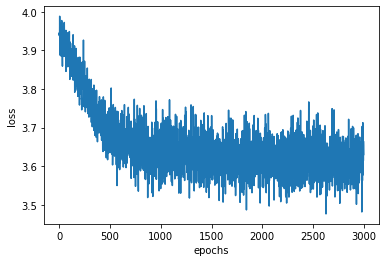

In [3]:
loss_func = lambda x, y: -log_prob1(x, y) # select the likelihood function to estimate

# Define the architecture of normalizing flow
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#torch.device("cpu")#

affine = True
n_flow = 16#8#32
generator = realnvpfc_model.RealNVP(2, n_flow, affine=affine, seqfrac=1/128).to(device)

# define the optimizer
optimizer = optim.Adam(generator.parameters(), lr = 1e-5)

n_epoch = 3000 # number of optimization steps
diversity = 1 # weight of the diversity loss
n_samples = 512 # number of samples in each optimization step

# start optimization
loss_list = []
sample_list = []
for k in range(n_epoch):
    x_samples_transformed, logdet = generator.reverse(torch.randn((n_samples, 2)).to(device))
    x_samples = 2 * torch.sigmoid(x_samples_transformed) - 1
    det_sigmoid = torch.sum(-x_samples_transformed - 2 * torch.nn.Softplus()(-x_samples_transformed), -1)
    logdet = logdet + det_sigmoid

    loss = torch.mean(loss_func(x_samples[:, 0], x_samples[:, 1]) - diversity * logdet)
    loss_list.append(loss.detach().cpu().numpy())

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(generator.parameters(), 1e-5)
    optimizer.step()

    if (k + 1) % 300 == 0:
        print(f"epoch: {k:}, loss: {loss.item():.5f}")
        sample_list.append(x_samples.detach().cpu().numpy())

plt.figure(), plt.plot(loss_list), plt.xlabel('epochs'), plt.ylabel('loss')

torch.Size([1444, 2])


[Text(0.5, 0, 'Learned distribution')]

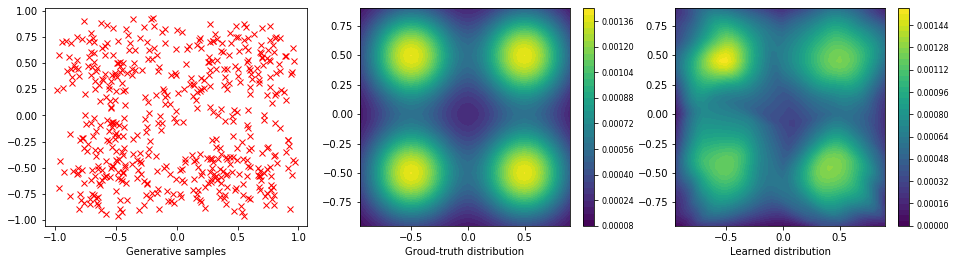

In [4]:
generator.training = False
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# plot generative samples
x_samples_transformed, logdet = generator.reverse(torch.randn((n_samples, 2)).to(device))
x_samples = 2 * torch.sigmoid(x_samples_transformed) - 1
x_generated = x_samples.detach().cpu().numpy()
# plt.figure(), plt.plot(x_generated[:, 0], x_generated[:, 1], 'rx')
# plt.title('Generative samples')
axs[0].plot(x_generated[:, 0], x_generated[:, 1], 'rx')
axs[0].set(xlabel='Generative samples')

# plot the ground-truth distribution
x_range = np.arange(-0.95, 0.95, 0.05)
y_range = np.arange(-0.95, 0.95, 0.05)

X, Y = np.meshgrid(x_range, y_range)
value = loss_func(torch.tensor(X), torch.tensor(Y)).numpy()
Z = np.array(value)
prob_true = np.exp(-Z) / np.sum(np.exp(-Z))

# fig = plt.figure(figsize=(6,5))
# left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
# ax = fig.add_axes([left, bottom, width, height]) 
# cp = plt.contourf(X, Y, prob_true, 40)
# cp = plt.contour
# cp = plt.colorbar()
# plt.title('Groud-truth distribution')
im = axs[1].contourf(X, Y, prob_true, 40)
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.tick_params(labelsize=8)
axs[1].set(xlabel='Groud-truth distribution')

# plot the learned distribution
X_reshape = X.reshape((-1, 1))
Y_reshape = Y.reshape((-1, 1))
XY_reshape = np.concatenate([X_reshape, Y_reshape], -1).astype(np.float32)
XY_reshape_torch = torch.tensor(XY_reshape).to(device)
XY_reshape_transformed = torch.log(1+XY_reshape_torch+1e-8) - torch.log(1-XY_reshape_torch+1e-8)
print(XY_reshape_transformed.shape)
random_samples, logdet = generator.forward(XY_reshape_transformed)
det_sigmoid = torch.sum(XY_reshape_transformed + 2 * torch.nn.Softplus()(-XY_reshape_transformed), -1)
logdet = logdet + det_sigmoid


logprob = logdet.cpu().detach().numpy() - 0.5 * np.sum((random_samples.cpu().detach().numpy())**2+np.log(2*np.pi), -1)
logprob = logprob.reshape(X.shape)
prob = np.exp(logprob) / np.sum(np.exp(logprob))

# fig = plt.figure(figsize=(6,5))
# left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
# ax = fig.add_axes([left, bottom, width, height]) 
# cp = plt.contourf(X_reshape.reshape((len(x_range), len(y_range))), Y_reshape.reshape((len(x_range), len(y_range))), prob, 40)
# cp = plt.contour
# cp = plt.colorbar()
# plt.title('Learned distribution')
im = axs[2].contourf(X_reshape.reshape((len(x_range), len(y_range))), Y_reshape.reshape((len(x_range), len(y_range))), prob, 40)
cbar = fig.colorbar(im, ax=axs[2])
cbar.ax.tick_params(labelsize=8)
axs[2].set(xlabel='Learned distribution')